<a href="https://colab.research.google.com/github/crispitagorico/Neural-SPDEs/blob/main/NavierStokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone "https://github.com/zongyi-li/fourier_neural_operator.git"
!git clone "https://github.com/crispitagorico/Neural-SPDEs.git"

Cloning into 'Neural-SPDEs'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21 (delta 4), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [4]:
# %cd fourier_neural_operator/
%cd Neural-SPDEs/

/content/Neural-SPDEs


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.optim as optim

from utilities import MatReader, LpLoss, count_params
from neuralSPDE_2D import NeuralFixedPoint

torch.manual_seed(0)
import warnings
warnings.filterwarnings('ignore')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
reader = MatReader('../drive/MyDrive/NavierStokes_V1e-5_N1200_T20.mat')
data = reader.read_field('u')

In [8]:
ntrain = 1000
ntest = 200

batch_size = 20
epochs = 500
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5
step = 1

dim_x, dim_y = 64, 64
t0 = 9
T = 20 - (t0 + 1)

u0_train = data[:ntrain,...,t0][:,None,...]
u_train = data[:ntrain,...,t0+1:t0+T+1]
xi_train = torch.ones((ntrain, 1, dim_x, dim_y, T))

u0_test = data[-ntest:,...,t0][:,None,...]
u_test = data[-ntest:,...,t0+1:t0+T+1]
xi_test = torch.ones((ntest, 1, dim_x, dim_y, T))

# # uncomment if using the NS forcing 
# grid_xy = get_grid(ntrain, dim_x, dim_y)
# xi_true = 0.1*(torch.sin(2*np.pi*(grid_xy[:,0]+ grid_xy[:,1])) + torch.cos(2*np.pi*(grid_xy[:,0]+ grid_xy[:,1])))[:,None,...,None]
# xi_train = torch.cat([xi_true.repeat(1,1,1,1,T),xi_train],dim=1)
# xi_test = torch.cat([xi_true.repeat(1,1,1,1,T)[:ntest,...],xi_test],dim=1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_train, xi_train, u_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_test, xi_test, u_test), batch_size=batch_size, shuffle=False)

In [9]:
# model = NeuralFixedPoint(modes1=16, modes2=16, modes3=8, in_channels=1, hidden_channels=64, forcing_channels=1, out_channels=1, T=T, n_iter=4).cuda()
model = NeuralFixedPoint(modes1=16, modes2=16, modes3=8, in_channels=1, hidden_channels=32, forcing_channels=1, out_channels=1, T=T, n_iter=4).cuda()

print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0025, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

2102689


In [10]:
myloss = LpLoss(size_average=False)

for ep in range(epochs):

    model.train()
    
    train_loss = 0.
    for u0_, xi_, u_ in train_loader:

        loss = 0.

        u0_ = u0_.to(device)
        xi_ = xi_.to(device)
        u_ = u_.to(device)

        u_pred = model(u0_, xi_)

        loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    test_loss = 0.
    with torch.no_grad():
        for u0_, xi_, u_ in test_loader:
            
            loss = 0.
            
            u0_ = u0_.to(device)
            xi_ = xi_.to(device)
            u_ = u_.to(device)

            u_pred = model(u0_, xi_)

            loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

            test_loss += loss.item()

    scheduler.step()
    print('Epoch {:04d} | Total Train Loss {:.6f} | Total Test Loss {:.6f}'.format(ep, train_loss / ntrain, test_loss / ntest))
    

Epoch 0000 | Total Train Loss 0.543853 | Total Test Loss 0.382119


KeyboardInterrupt: ignored

**Visualize results**

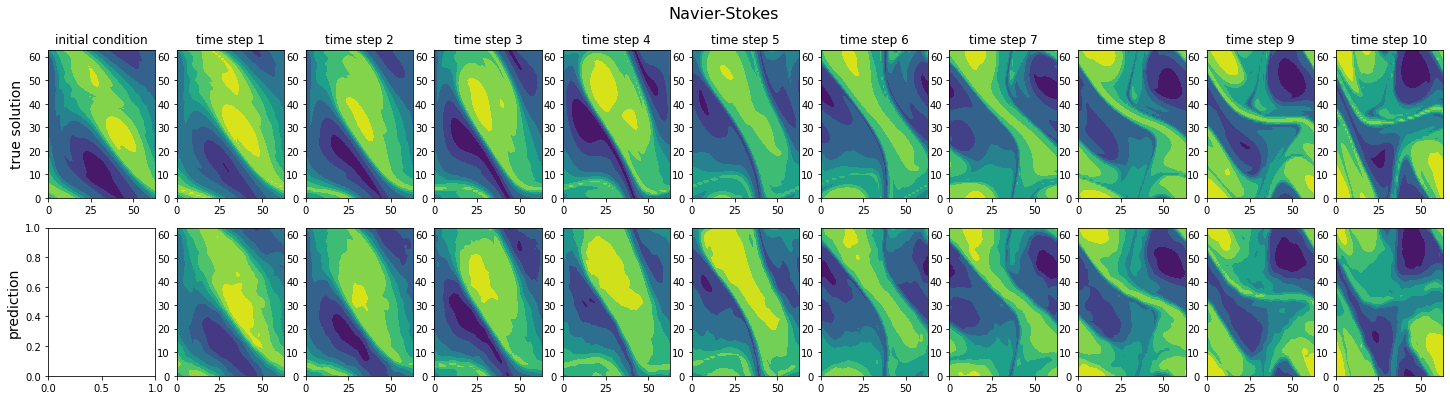

In [ ]:
k = 2

# u0 = u0_train[k][None,...].to(device)
# u = u_train[k][None,...].to(device) 
# xi = xi_train[k][None,...].to(device)
u0 = u0_test[k][None,...].to(device)
u = u_test[k][None,...].to(device) 
xi = xi_test[k][None,...].to(device)
u_pred = model(u0,xi)

fig, ax = plt.subplots(2,T+1,figsize=(25,6))
plt.suptitle('Navier-Stokes', fontsize=16)

ax[0][0].contourf(u0[0,0,...].detach().cpu().numpy())
ax[0][0].set_title('initial condition')
ax[0][0].set_ylabel('true solution', fontsize=14)
ax[1][0].set_ylabel('prediction', fontsize=14)

for i in range(T):
  ax[0][i+1].contourf(u[0,...,i].detach().cpu().numpy())
  ax[1][i+1].contourf(u_pred[0,0,...,i].detach().cpu().numpy())
  ax[0][i+1].set_title(f'time step {i+1}')
plt.show()